## 6. Solver applications

Geostack also contains a range of geospatial solvers. These represent some physical process which is more complex to model than a script. A wide range of these exist or are under development. Only two short examples will be shown here, more details are available on our wiki page.

### Particle model

The particle solver allows the user to track the motion of particles under a given acceleration. This was primarily designed for geospatial applications such as lofted debris in wind, but can be applied to any general motion of particles. A solver instance is created by:

In [1]:
from geostack.solvers import Particle

solver = Particle()

A configuration must be supplied in json containing scripts to define the initial state and updates to the solver. Here we model a satellite under gravity, with force proportional to the reciprocal of the distance squared, with a drag force proportional to the square of speed. The configuration for the particle solver is:

In [2]:
config = {
    "dt": 0.01,
    "initialisationScript" : '''
        velocity.x = 0.5;
        velocity.y = 0.5;
    ''',
    "updateScript" : '''
        acceleration = -normalize(position)*pow(length(position), -2.0)
                       -0.01*velocity*length(velocity);
    '''
}

where
- _dt_ is the solver time step.
- _initialisationScript_ defines the initial conditions for the solver. This sets the initial velocity in the x and y directions to 0.5.
- _updateScript_ defines the acceleration on each particle. This is a function of the current _position_ and _velocity_ vectors.

The solver needs a set of particles to operate over in a Vector object. Here we create one at x = 1:

In [3]:
from geostack.vector import Vector

particles = Vector()
particles.addPoint( [1, 0, 0] );

The solver is initialised with the configuration and particles:

In [4]:
import json

solver.init(json.dumps(config), particles);

Finally the solver is run for 1000 time steps. The coordinates of the particles are stored for plotting in _c_x_ and _c_y_:

In [5]:
c = particles.getCoordinate(0)
c_x = [c[0]]
c_y = [c[1]]
for iter in range(0, 1000):
    solver.step()
    c = particles.getCoordinate(0)
    c_x.append(c[0])
    c_y.append(c[1])

The results can be plotted using:

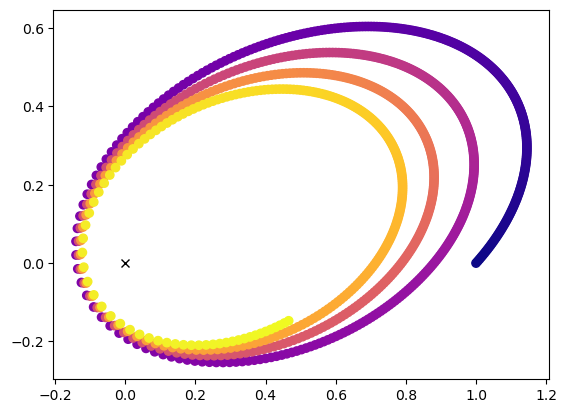

In [6]:
import numpy as np
import matplotlib.pyplot as plt

t = np.arange(len(c_x))
fig = plt.figure()
plt.scatter(c_x, c_y, c=t, cmap='plasma')
plt.plot([0], [0], 'kx');

Showing a decaying elliptical orbit.

### Level set method

The level set method is a raster-based method for tracking a moving interface. The Geostack implementation only allows outward movement of the interface and is suitable for applications to fire spread, shortest travel time and basic flood models. As with the particle model a level set instance is created using:

In [7]:
from geostack.solvers import LevelSet

solver = LevelSet()

In this example we implement a [basic flood model](https://gitlab.com/geostack/library/-/wikis/Bernoulli%20flood%20model%20(Python)) based on the Bernoulli equation. The model is only suitable for flooding connected regions as it assumes the entire water body is at the same height as, in essence, it is a moving fill with a physically derived outward speed. The model requires a elevation map of vertical height above a given datum (sea level here):

In [9]:
from geostack.raster import Raster

elev = Raster(name = 'elev')
elev.read('./data/06_example.tif')

as well as a starting condition for the level set as a Vector object. In this example this is a point of radius 500 m at longitude and latitude coordinates (148.82465, -35.61888), the shape of which defines the two-dimensional starting conditions. The level set only represents the two-dimensional boundary of the water and contains no depth information, this is calculated separately from the difference between a static height and the ground elevation.

In [11]:
from geostack.vector import Vector
from geostack.core import ProjectionParameters

v = Vector()
v.setProjectionParameters(ProjectionParameters.from_proj4("+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs"))
point_id = v.addPoint( [148.82465, -35.61888] )
v.setProperty(point_id, "radius", 500)

The level set solver allows a number of auxiliary Raster to be linked to and used within the solver. We need two additional layers, one holding the current water depth, called _depth_ here, and one holding a mask of the wetted region, called _extent_. These are used to calculate the overall water height.

In [12]:
from geostack.definitions import ReductionType

depth = Raster(name = 'depth')
depth.setReductionType(ReductionType.Sum)
extent = Raster(name = 'extent')
extent.setReductionType(ReductionType.Sum)

where the two Rasters have the _ReductionType.Sum_ reduction type set. This means every time they are used in a script the sum of all values in valid (non no-data) cells is calculated and available as _reduceVal_. The initial water height is set to a required initial height (the Australian Height Datum is used here):

In [13]:
height = 1200

The Bernoulli equation gives the outward speed of water at the bottom of a column as the square root of twice the local water height multiplied by gravity. A constant head loss term of 100 is also included. These are encoded into the build script, which sets the outward normal speed of the interface, and the update script, which is run for every cell within the interface at each time step. The configuration for this is:

In [14]:
config = {
    "resolution": 30,
    "projection": "+proj=utm +zone=55 +south +ellps=GRS80 +towgs84=0,0,0,0,0,0,0 +units=m +no_defs",
    "buildScript": "REAL c = 2.0*9.8*(height-elev)-100.0; speed = c > 0.0 ? sqrt(c) : 0.0;",
    "updateScript": "depth = max(height-elev, 0.0); extent = depth > 0.0 ? 1.0 : 0.0;"
}

The build script calculates the local water speed including head loss as _c_, then if _c_ is greater than zero sets the outward speed of the level set to the square root of _c_. The update script calculates the depth in each cell from the current (overall) water height and local elevation. As the depth Raster has a summation reduction applied this depth is integrated over all cells giving the total water volume (the cell resolution is not used as it cancels in the processing, but the true volume is this value multiplied by the resolution squared). The update script also sets the extent Raster to one if the water depth is greater than zero. Again, as this has a summation reduction applied this extent is integrated over all cells giving the total water area (again the cell resolution is not used, so the true area is this value multiplied by the resolution squared).

As well as Rasters, the level set can take a set of scalar values using a _Variables_ object. These are read-only within any scripts. Here we need to store height to use it within the scripts:

In [15]:
from geostack.core import Variables

variables = Variables()
variables.set("height", height)

The external layers are passed to the solver using a special RasterPtrList object, which holds references to the Rasters:

In [16]:
from geostack.raster import RasterPtrList

inputLayers = RasterPtrList()
inputLayers.append(elev)

outputLayers = RasterPtrList()
outputLayers.append(depth)
outputLayers.append(extent)

Finally the solver is initialised:

In [17]:
import json

solver.init(json.dumps(config), v, variables, inputLayers, outputLayers);

And run by looping until the internal time is greater than 20 minutes:

In [18]:
solver.step()
volumeInitial = depth.reduceVal
while solver.getParameters()['time'] <= 1200:

    solver.step()
    volume = depth.reduceVal
    area = extent.reduceVal
    
    dh = (volume-volumeInitial)/area
    height = height-dh
    variables.set("height", height)

Within the loop the reductions for the volume and area are calculated and the height updated accordingly. The results are shown below coloured by time of arrival in each cell:

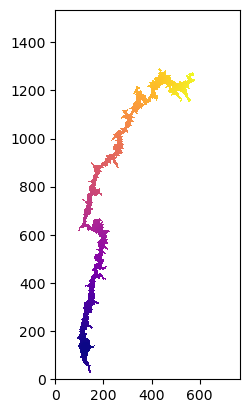

In [19]:
# Plot raster
import matplotlib.pyplot as plt
plt.imshow(solver.getArrival().data, interpolation='none', cmap='plasma', origin='lower');